# Non-stationary Contextual Multi-armed Bandit
## Introduction

- Contextual MAB aims to find the best policy given context features as side information.
- One key assumption: the underlying relationship between context features and rewards are fixed or move very slowly.

### Problem
- In many real world situations, this is not the case. 
- Factors can change suddenly and dramatically (non-stationary)

### Examples
- a user's interest in watching the NBA would suddenly drop in June when the season is over. 
- a user moved to another city or country.

Therefore, in these situations, many alogrithms will be stuck in sub-optimal decisions for a long-time or forever.

### Illustration
This notebook implemented a popular contextual bandit algorithm: LinUCB


### Solutions
We will focus on one of the solutions to this problem. 

The dLinUCB algorithm proposed by Wu et al in 
__[Learning Contextual Bandits in a Non-stationary Environment](https://arxiv.org/pdf/1805.09365.pdf)__ 


## Background
One of the popular algorithms for contextual bandit is the LinUCB.

$E[r_{t,a}|x_{t,a}] = x_{t,a}^{T}\theta_{a}^{*}$

x is context features, $\theta$ is weights. So assumes the expected reward for an action under given context is a linear combination of features.

Weights are calculated by a ridge regression over all the previous contexts encountered vs observed reward


## References
[1] Lihong Li, Wei Chu, John Langford, and Robert E Schapire. 2010. A contextualbandit
approach to personalized news article recommendation. In Proceedings of
19th WWW. ACM, 661–670.

[2]Wu, Q., Iyer, N. and Wang, H., 2018. Learning Contextual Bandits in a Non-stationary Environment. arXiv preprint arXiv:1805.09365.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import inv
plt.style.use('seaborn-whitegrid')

#Generate ground truth models
#Here we assume the reward is linear in the context.
#each action has a theta which is the weights for the context feature vector
np.random.seed(0)
N_FEATURE = 3
N_ACTION = 5
TRUE_THETAS = np.random.rand(N_ACTION,N_FEATURE) * 5. - 2.
def get_true_thetas(a):
    return TRUE_THETAS[a]
def get_true_reward(x,a):
    return np.dot(x,get_true_thetas(a))
def get_rand_context():
    return np.random.randint(0,5,(N_FEATURE))
def get_optimal_action(x):
    return np.argmax([get_true_reward(x,a) for a in range(N_ACTION)])

print('true thetas for actions')
for a in range(N_ACTION):
    print('action ' + str(a) + ': ' + str(get_true_thetas(a)))


true thetas for actions
action 0: [0.74406752 1.57594683 1.01381688]
action 1: [0.72441591 0.118274   1.22947057]
action 2: [0.18793606 2.458865   2.8183138 ]
action 3: [-0.08279241  1.95862519  0.6444746 ]
action 4: [ 0.84022281  2.62798319 -1.64481971]


In [3]:
#contextual MAB
class Bandit():
    def __init__(self, n_feature, n_action, policy):
        self.policy = policy
        self.thetas = np.zeros((n_action,n_feature))
        self.n_a = n_action
        self.n_f = n_feature
        self.Ds = [np.zeros(3).reshape(1,3)] * self.n_a
        self.Cs = [0] * self.n_a
        
    def pick_action(self,x):
        if self.policy == 'random':
            return np.random.randint(0,self.n_a)
        elif self.policy == 'egreedy':
            if np.random.rand()<0.2:
                return np.random.randint(0,self.n_a)
            else:
                return np.argmax([np.dot(x,self.thetas[a]) for a in range(self.n_a)])
        elif self.policy == 'LinUCB':
            delta = 0.3
            max_E = np.NINF
            best_a = 0
            for a in range(self.n_a):
                D = self.Ds[a]
                A = np.dot(D.T,D) + np.identity(self.n_f)
                A_inverse = inv(A)
                alpha = 1. + np.sqrt(np.log(2./delta)/2.)
                bound = alpha * np.sqrt(np.dot(np.dot(x.T, A_inverse), x))
                E = np.dot(x.T,self.thetas[a]) + bound
                if E > max_E:
                    max_E = E
                    best_a = a
                
            return best_a
        else:
            raise Exception('no policy found')
    def update_model(self,x,a,r):
        d = len(x)
        self.Ds[a] = np.append(self.Ds[a],[x],axis=0)
        self.Cs[a] = np.append(self.Cs[a],r)
        D = self.Ds[a]
        C = self.Cs[a]
        inverse = inv(np.dot(D.T, D) + np.identity(d))
        new_theta = np.dot(np.dot(inverse,D.T), C)
        self.thetas[a] = new_theta
        
    

thetas
action 0: [0.76287595 1.54506178 0.98971372]
action 1: [0.71712769 0.15407417 1.17898045]
action 2: [0.20130736 2.45281721 2.8080032 ]
action 3: [ 0.55837785  0.79749584 -0.31893296]
action 4: [ 0.57719748  0.         -0.89501524]
thetas
action 0: [0.74909909 1.54072679 1.01018325]
action 1: [0.60124374 0.56754798 0.91212357]
action 2: [0.20198561 2.45099873 2.80703605]
action 3: [-0.00589564  1.87902373  0.6707127 ]
action 4: [ 1.69780531  0.58604023 -0.52572484]


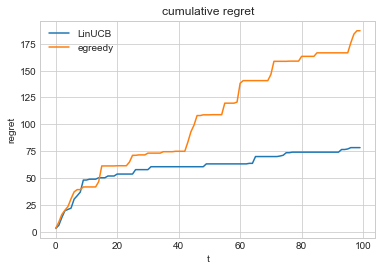

In [4]:
#run simulation
ITERATIONS = 100
def run_experiment(iterations, policy):
    np.random.seed(0)
    regret = 0.
    regret_list = []
    model = Bandit(N_FEATURE, N_ACTION, policy)
    for t in range(iterations):
        context = get_rand_context()
        a = model.pick_action(context)
        r = get_true_reward(context,a)
        model.update_model(context,a,r)
        regret += abs(r - get_true_reward(context,get_optimal_action(context)))
        regret_list.append(regret)
    
    print('thetas')
    for a in range(model.n_a):
        print('action ' + str(a) + ': ' + str(model.thetas[a]))
    plt.plot(regret_list, label=policy)
    return

fig = plt.figure()
ax = plt.axes()
plt.title('cumulative regret')
plt.xlabel('t')
plt.ylabel('regret')

run_experiment(ITERATIONS, 'LinUCB')
run_experiment(ITERATIONS, 'egreedy')
plt.legend()
